In [1]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')

import warnings

warnings.filterwarnings('ignore')

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import re
from scipy.io import wavfile
from scipy.fftpack import fft
import cv2
import os
import librosa
import librosa.display
import IPython.display as ipd
from glob import glob
import skimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tqdm import tqdm
import tempfile
import plotly.graph_objects as go

In [10]:
from gudhi import RipsComplex
import gudhi as gd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import wasserstein_distance
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from gudhi.representations import Landscape
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from gudhi.representations import PersistenceImage
from pathos.multiprocessing import ProcessingPool as Pool
from multiprocessing import cpu_count
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

from pydub import AudioSegment
from pydub.utils import which
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"
AudioSegment.converter = "/opt/homebrew/bin/ffmpeg"
AudioSegment.ffprobe = "/opt/homebrew/bin/ffprobe"

In [11]:
# import kagglehub

# # Download latest version
# path_radvess = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# print("Path to dataset files:", path_radvess)

In [12]:
# import kagglehub

# # Download latest version
# path_cremad = kagglehub.dataset_download("ejlok1/cremad")

# print("Path to dataset files:", path_cremad)

In [13]:
# import kagglehub

# # Download latest version
# path_savee = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")

# print("Path to dataset files:", path_savee)

In [14]:
# import kagglehub

# # Download latest version
# path_tess = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

# print("Path to dataset files:", path_tess)

In [15]:
import os
from tqdm import tqdm
import numpy as np
import torch
import torchaudio
import random
from pydub import AudioSegment

myPath_radvess = 'radvess/1/'

myEmotionMapRadvess = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
}

# ------------------------------------------------------------
# --- Audio Augmentation Helpers (simple torch/torchaudio) ---
# ------------------------------------------------------------
def add_noise2(wav, noise_level=0.02):
    noise = torch.randn_like(wav) * noise_level
    return wav + noise

def time_shift(wav, shift_max=0.2):
    shift = int(random.uniform(-shift_max, shift_max) * wav.shape[-1])
    return torch.roll(wav, shifts=shift)

def pitch_shift(wav, sr, semitones=(-1, 1)):
    steps = random.uniform(*semitones)
    rate = 2 ** (steps / 12)
    wav = torchaudio.functional.resample(wav, sr, int(sr * rate))
    wav = torchaudio.functional.resample(wav, int(sr * rate), sr)
    return wav[..., :wav.shape[-1]]  # crop back to original length

def apply_spec_augment(spec, freq_mask=10, time_mask=20):
    spec = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask)(spec)
    spec = torchaudio.transforms.TimeMasking(time_mask_param=time_mask)(spec)
    return spec

# ------------------------------------------------------------
# --- Dataset Loader with Augmentation ---
# ------------------------------------------------------------
def loadFiles_radvess(aDirectory, sr=16000, augment=True):
    myEmotionsSounds, myActors, myEmotions = [], [], []
    resampler = torchaudio.transforms.Resample(orig_freq=48000, new_freq=sr)

    for myFolder in tqdm(os.listdir(aDirectory)):
        folder_path = os.path.join(aDirectory, myFolder)
        if not os.path.isdir(folder_path):
            continue

        for myFile in os.listdir(folder_path):
            if myFile.endswith(".wav"):
                emotion_id = int(myFile.split('-')[2])
                myEmotion = myEmotionMapRadvess.get(emotion_id)
                if myEmotion not in ['calm', 'surprised']:
                    wav, file_sr = torchaudio.load(os.path.join(folder_path, myFile))
                    if file_sr != sr:
                        wav = resampler(wav)

                    # Base version
                    myEmotionsSounds.append(wav)
                    myActors.append(myFolder)
                    myEmotions.append(myEmotion)

                    # Augmented version (optional)
                    if augment:
                        aug_wav = wav.clone()
                        if random.random() < 0.5:
                            aug_wav = add_noise2(aug_wav, 0.02)
                        if random.random() < 0.5:
                            aug_wav = time_shift(aug_wav)
                        if random.random() < 0.3:
                            aug_wav = pitch_shift(aug_wav, sr)
                        myEmotionsSounds.append(aug_wav)
                        myActors.append(myFolder)
                        myEmotions.append(myEmotion)
    return myEmotionsSounds, myActors, myEmotions


In [16]:
from pydub import AudioSegment
import numpy as np
import random

def add_noise2(sound: AudioSegment, noise_level=0.02):
    samples = np.array(sound.get_array_of_samples()).astype(np.float32)
    noise = np.random.randn(len(samples)) * noise_level * (samples.std() + 1e-8)
    noisy = np.clip(samples + noise, -2**15, 2**15 - 1).astype(np.int16)
    return sound._spawn(noisy.tobytes())

def time_shift(sound: AudioSegment, max_shift_ms=100):
    shift = random.randint(-max_shift_ms, max_shift_ms)
    if shift > 0:
        return AudioSegment.silent(duration=shift) + sound[:-shift]
    elif shift < 0:
        return sound[-shift:] + AudioSegment.silent(duration=-shift)
    return sound

def pitch_shift(sound: AudioSegment, semitone_range=(-1.0, 1.0)):
    steps = random.uniform(*semitone_range)
    new_sr = int(sound.frame_rate * (2.0 ** (steps / 12.0)))
    shifted = sound._spawn(sound.raw_data, overrides={'frame_rate': new_sr})
    return shifted.set_frame_rate(sound.frame_rate)

def add_noise(
    sound: AudioSegment,
    noise_level=0.02,
    p_noise=0.7,
    p_shift=0.6,
    p_pitch=0.5,
    max_shift_ms=100,
    semitone_range=(-1.0, 1.0),
    shuffle_ops=True,
):
    """
    Apply augmentations probabilistically, ensuring at least one is applied.
    """
    ops = [
        ("noise", lambda s: add_noise2(s, noise_level)),
        ("shift", lambda s: time_shift(s, max_shift_ms)),
        ("pitch", lambda s: pitch_shift(s, semitone_range)),
    ]
    probs = {"noise": p_noise, "shift": p_shift, "pitch": p_pitch}

    if shuffle_ops:
        random.shuffle(ops)

    applied = []
    out = sound
    for name, fn in ops:
        if random.random() < probs[name]:
            out = fn(out)
            applied.append(name)

    # Guarantee at least one
    if not applied:
        name, fn = random.choice(ops)
        out = fn(out)
        applied.append(name)

    return out


In [17]:
myPath_radvess = 'radvess/1/'
myEmotionMapRadvess = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
}

def loadFiles_radvess(aDirectory):
    myEmotionsSounds, myActors, myEmotions = [], [], []
    for myFolder in tqdm(os.listdir(aDirectory)):
        for myFile in tqdm(os.listdir(aDirectory + myFolder)):
            if myFile.endswith(".wav"):
                myEmotion = myEmotionMapRadvess[int(myFile.split('-')[2])]
                for i in range(2):
                    if myEmotion != 'calm' and myEmotion != 'surprised':
                        sound = AudioSegment.from_file(os.path.join(aDirectory + myFolder, myFile))
                        if i % 2 == 0:
                            sound = add_noise(sound, noise_level=0.1)
                        myEmotionsSounds.append(sound)
                        myActors.append(myFolder)
                        myEmotions.append(myEmotion)
    return myEmotionsSounds, myActors, myEmotions

In [18]:
myPath_cremad = 'cremad/1/AudioWAV/'
myEmotionMapCremad = {
    'NEU': 'neutral', 'HAP': 'happy', 'SAD': 'sad', 'ANG': 'angry', 'FEA': 'fearful', 'DIS': 'disgust'
}
def loadFiles_cremad(aDirectory):
    myEmotionsSounds, myActors, myEmotions = [], [], []
    for myFile in tqdm(os.listdir(aDirectory)):
        if myFile.endswith(".wav"):
            myEmotion = myEmotionMapCremad[(myFile.split('_')[2].split('.')[0])]
            if myEmotion != 'calm' and myEmotion != 'surprised':
                for i in range(2):
                    myActor = myFile.split('_')[0]
                    sound = AudioSegment.from_file(os.path.join(aDirectory, myFile))
                    if i % 2 == 0:
                        sound = add_noise(sound, noise_level=0.1)
                    myEmotionsSounds.append(sound)
                    myActors.append(myActor)
                    myEmotions.append(myEmotion)
    return myEmotionsSounds, myActors, myEmotions

In [19]:
myPath_savee = 'savee/1/ALL/'
myEmotionMapSavee = {
    'n': 'neutral', 'h': 'happy', 'sa': 'sad', 'a': 'angry', 'f': 'fearful', 'd': 'disgust', 'su': 'surprised'
}
def loadFiles_savee(aDirectory):
    myEmotionsSounds, myActors, myEmotions = [], [], []
    for myFile in tqdm(os.listdir(aDirectory)):
        if myFile.endswith(".wav"):
            myEmotion = myEmotionMapSavee[(myFile.split('_')[1].split('.')[0])[:-2]]
            if myEmotion != 'calm' and myEmotion != 'surprised':
                for i in range(2):
                    myActor = myFile.split('_')[0]
                    sound = AudioSegment.from_file(os.path.join(aDirectory, myFile))
                    if i % 2 == 0:
                        sound = add_noise(sound, noise_level=0.1)
                    myEmotionsSounds.append(sound)
                    myActors.append(myActor)
                    myEmotions.append(myEmotion)
    return myEmotionsSounds, myActors, myEmotions

In [20]:
myPath_tess = 'tess/1/TESS Toronto emotional speech set data/'
myEmotionMapTess = {
    'neutral': 'neutral', 'happy': 'happy', 'sad': 'sad', 'angry': 'angry', 'fear': 'fearful', 'disgust': 'disgust', 'pleasant': 'surprised', 'pleasant_surprised': 'surprised'
}
def loadFiles_tess(aDirectory):
    myEmotionsSounds, myActors, myEmotions = [], [], []
    for myFolder in tqdm(os.listdir(aDirectory)):
        if len(myFolder.split('_')) >= 2:
            myActor = myFolder.split('_')[0]
            myEmotion = myEmotionMapTess[myFolder.split('_')[1].lower()]
            if myEmotion != 'calm' and myEmotion != 'surprised':
                for myFile in tqdm(os.listdir(aDirectory + myFolder)):
                    if myFile.endswith(".wav"):
                        for i in range(2):
                            sound = AudioSegment.from_file(os.path.join(aDirectory + myFolder, myFile))
                            if i % 2 == 0:
                                sound = add_noise(sound, noise_level=0.1)
                            myEmotionsSounds.append(sound)
                            myActors.append(myActor)
                            myEmotions.append(myEmotion)
    return myEmotionsSounds, myActors, myEmotions

In [21]:
def getWaveform(aPath, aPathName):
    mySignal, mySampleRate = librosa.load(aPath)
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(mySignal, sr=mySampleRate)
    plt.title(F'The {aPathName} Sound Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
    print(F"The {aPathName} Sound: ")
    sound = ipd.Audio(mySignal, rate=mySampleRate)
    return sound

In [22]:
def doMelSpectrogram(aSoundFiles, aFixLength = False):
    mySampleRate = 44100
    myMelSpectrograms = []
    for i in tqdm(range(len(aSoundFiles))):
        myAudioSegment = aSoundFiles[i]
        myTempFile = tempfile.NamedTemporaryFile(delete=False, suffix=".wav")
        myTempFilePath = myTempFile.name
        myTempFile.close()
        myAudioSegment.export(myTempFilePath, format="wav")
        mySignal, mySampleRate = librosa.load(myTempFilePath, sr=mySampleRate)
        os.remove(myTempFilePath)
        mel_spectrogram = librosa.feature.melspectrogram(y=mySignal, sr=mySampleRate, n_mels=128)
        mel_spectrogram_dbs = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)
        if aFixLength:
            mel_spectrogram_dbs = librosa.util.fix_length(mel_spectrogram_dbs, size=256, axis=1)
        myMelSpectrograms.append(mel_spectrogram_dbs)
    return myMelSpectrograms

In [23]:
def computeMfccs(aDbs, aNumMfcc=13):
    myMfccList = []
    for i in tqdm(range(len(aDbs))):
        myMfcc = librosa.feature.mfcc(S=aDbs[i], n_mfcc=aNumMfcc)
        myMfccList.append(myMfcc)
    return myMfccList

In [24]:
def showMelSpectrogram(aMelSpectrogram):
    myDfMelSpectrogram = pd.DataFrame(aMelSpectrogram)
    plt.figure(figsize=(10, 4))
    sns.heatmap(myDfMelSpectrogram, cmap='plasma', xticklabels=10, yticklabels=10)
    plt.title(f'Mel Spectrogram from an angry sound  (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency Bin')
    plt.show()

In [25]:
def showMfcc(aMfcc):
    librosa.display.specshow(aMfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC From an Angry Sound')
    plt.show()

In [26]:
def show3DPlot(aMelSpectrogram):
    fig = go.Figure(data=[
        go.Surface(z=aMelSpectrogram.T, colorscale='viridis')
    ])
    fig.update_layout(
        title='Mel Spectrogram from and angry sound 3-D plot (dB)',
        scene=dict(
            xaxis=dict(title='Time (s)'),
            yaxis=dict(title='Mel Frequency Bin'),
            zaxis=dict(title='Amplitude (dB)')
        )
    )
    fig.show()

## Preprocessing: Getting MFCCs and Spectrograms

In [30]:
myRadvessSounds, myRadvessActors, myRadvessEmotions = loadFiles_radvess(myPath_radvess)
myCremadSounds, myCremadActors, myCremadEmotions = loadFiles_cremad(myPath_cremad)
mySaveeSounds, mySaveeActors, mySaveeEmotions = loadFiles_savee(myPath_savee)
myTessSounds, myTessActors, myTessEmotions = loadFiles_tess(myPath_tess)


100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


In [29]:
myMelSpectrogramsRadvess = doMelSpectrogram(myRadvessSounds)
myMelSpectrogramsCremad = doMelSpectrogram(myCremadSounds)
myMelSpectrogramsSavee = doMelSpectrogram(mySaveeSounds)
myMelSpectrogramsTess = doMelSpectrogram(myTessSounds)

100%|██████████| 4800/4800 [00:15<00:00, 309.69it/s]


In [30]:
myMfccRadvess = computeMfccs(myMelSpectrogramsRadvess)
myMfccCremad = computeMfccs(myMelSpectrogramsCremad)
myMfccSavee = computeMfccs(myMelSpectrogramsSavee)
myMfccTess = computeMfccs(myMelSpectrogramsTess)

100%|██████████| 4800/4800 [00:00<00:00, 30778.66it/s]


## Computing Homologies!

In [31]:
def euclideanMetric(x, y):
    return np.linalg.norm(x - y)
def timeBasedEuclideanMetric(x, y):
    return np.linalg.norm(x[0] - y[0]) / (2) + np.linalg.norm(x[1:] - y[1:]) / (2)


In [32]:
def computerPersistenceDiagrams(aMatrix, aMaxLength, aMaxDim, aMetric, aPlot, aNormalize):
    # Preprocess matrix
    if aNormalize:
        myTimeRow = np.arange(aMatrix.shape[1])
        myNormalizedMatrix = (aMatrix - np.min(aMatrix)) / (np.max(aMatrix) - np.min(aMatrix))
        myTimeRow = myTimeRow / aMatrix.shape[1]
        myNewArr = np.vstack([myTimeRow, myNormalizedMatrix])
    else:
        myNewArr = aMatrix

    # Compute distance matrix
    myDistanceMatrix = squareform(pdist(myNewArr.T, metric=aMetric))
    myMaxLength = min(np.abs(myDistanceMatrix).max().max() / 3, aMaxLength)

    # Compute persistences
    myRipsComplex = RipsComplex(points=myNewArr.T, max_edge_length=myMaxLength, distance_matrix=myDistanceMatrix)
    mySimplexTree = myRipsComplex.create_simplex_tree(max_dimension=aMaxDim)
    mySimplexTree.compute_persistence()
    myPersistence = mySimplexTree.persistence()

    # Compute bd matrix
    myBd = []
    for i in range(aMaxDim):
        myBdMatrix = np.array([
            [birth, death] for dim, (birth, death) in myPersistence if dim == i and death != float('inf')
        ])
        myBd.append(myBdMatrix)

    # Plot if needed
    if aPlot:
        gd.plot_persistence_diagram(mySimplexTree.persistence())

    return myBd

In [33]:
def computerPersistenceDiagramsStar(args):
    return computerPersistenceDiagrams(*args)
def computePersistanceFromDb(aDb, aMaxLength, aMaxDim, aMetric, aPlot, aMaxDiagrams, aNormalize):
    myMat = []
    args = []
    for i, myCurr in enumerate(aDb):
        if i == aMaxDiagrams:
            break
        args.append((myCurr, aMaxLength, aMaxDim, aMetric, aPlot, aNormalize))

    with Pool(processes=cpu_count()) as pool:
        myMat = list(
            tqdm(
                pool.imap(computerPersistenceDiagramsStar, args),
                total=len(args),
                desc="Computing persistences"
            )
        )
    return myMat

In [34]:

def getPersistenceHeatMapSingle(myBdMatrix, aMax, aDim, aPlot, aShape):
    # print(myBdMatrix)
    myPersistenceImage = PersistenceImage(
        bandwidth= aMax / 50,
        weight=lambda x: np.sqrt((x[1] - x[0])**2),
        resolution=[aShape, aShape],
        im_range=[0, aMax, 0, aMax]
    )

    # If any persistence bd matrix found then compute heatmap
    if aDim < len(myBdMatrix) and len(myBdMatrix[aDim]) > 0:
        myHeatMap = myPersistenceImage.fit_transform([myBdMatrix[aDim]])[0]
        myHeatMap2d = myHeatMap.reshape(aShape, aShape)
        if aPlot:
            print(myHeatMap2d.shape)
            plt.figure()
            plt.imshow(myHeatMap2d, cmap='hot', origin='lower')
            plt.colorbar(label='Scaled Density')
            plt.title('Persistence Image')
            plt.xlabel('Birth')
            plt.ylabel('Persistence')
            plt.show()
        return myHeatMap2d
    else:
        return np.zeros((aShape, aShape))

def getPersistenceHeatMapSingleStar(args):
    return getPersistenceHeatMapSingle(*args)

def getPersitanceHeatMap(aArr, aMax, aMaxDim, aPlot = False, aShape = 32):
    myHeatmapArr = []
    args = []
    for i, myCurr in enumerate(aArr):
        for j in range(aMaxDim):
            args.append((myCurr, aMax, j, aPlot, aShape))

    with Pool(processes=cpu_count()) as pool:
        myHeatmapArr = list(
            tqdm(
                pool.imap(getPersistenceHeatMapSingleStar, args),
                total=len(args),
                desc="Computing persistences heat map"
            )
        )
    return myHeatmapArr

Computing persistences heat map:   0%|          | 0/2 [00:00<?, ?it/s]

(32, 32)
(32, 32)


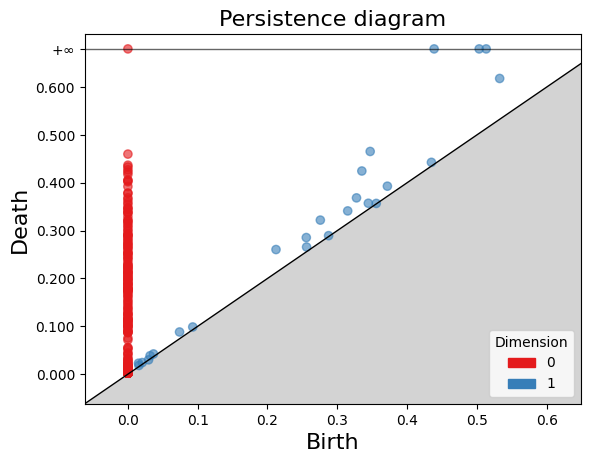

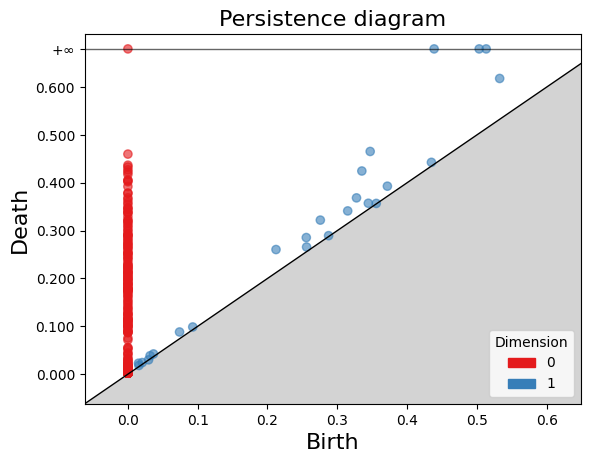

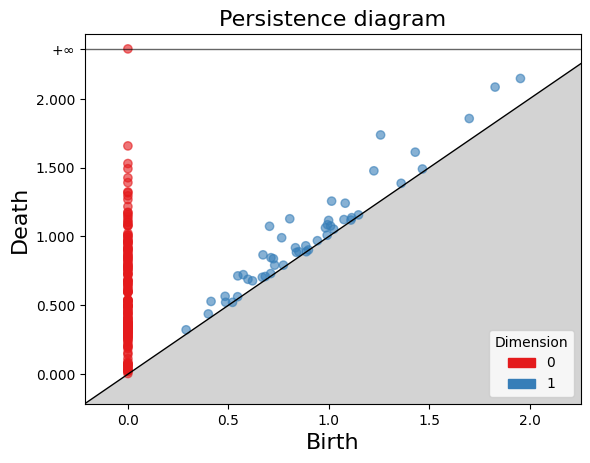

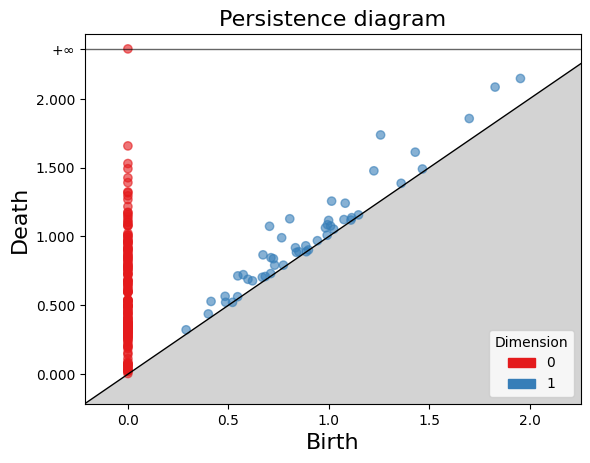

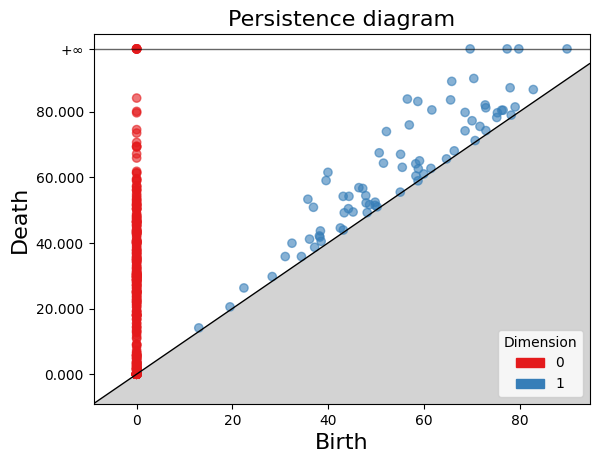

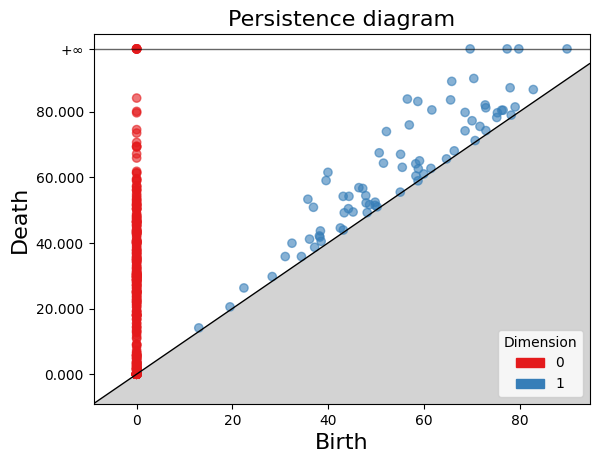

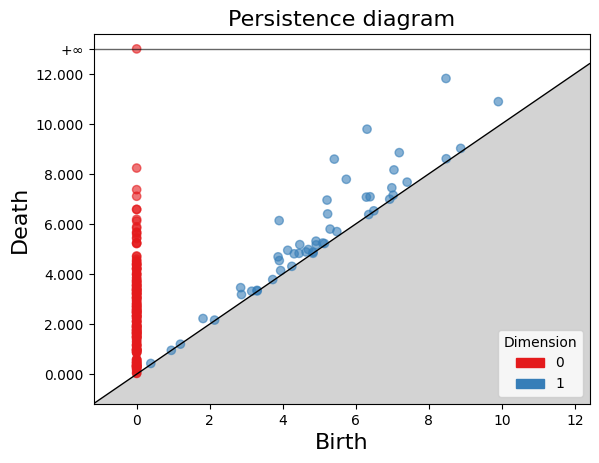

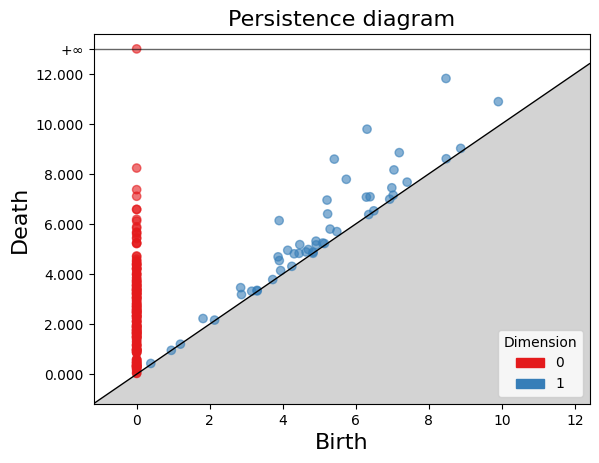

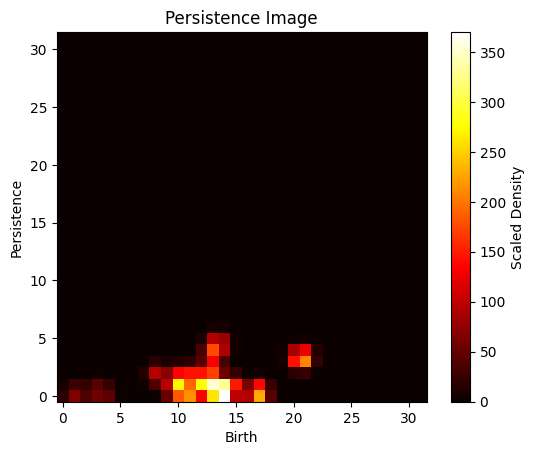

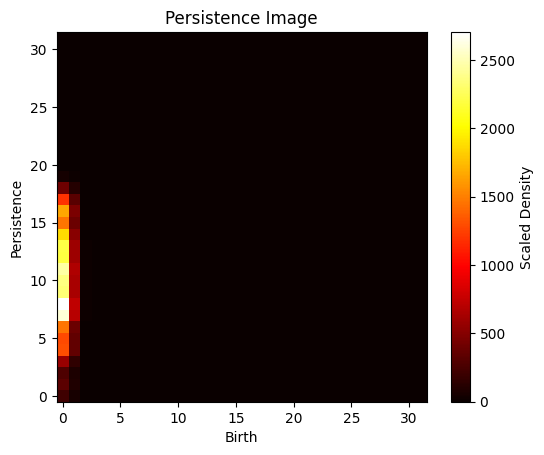

Computing persistences heat map:   0%|          | 0/2 [00:00<?, ?it/s]

(32, 32)(32, 32)



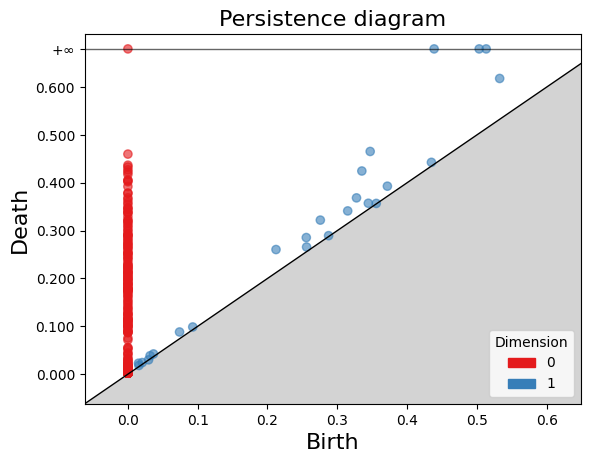

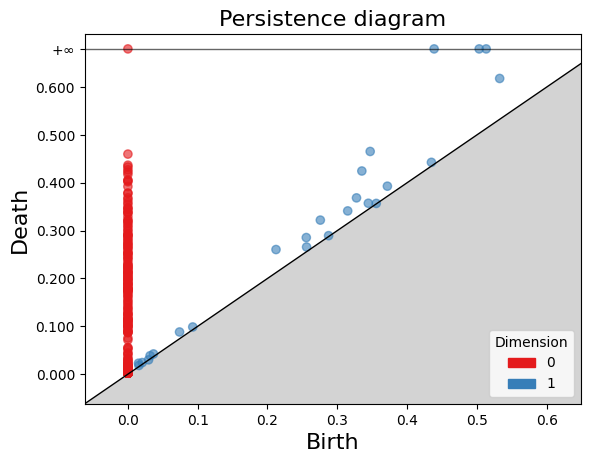

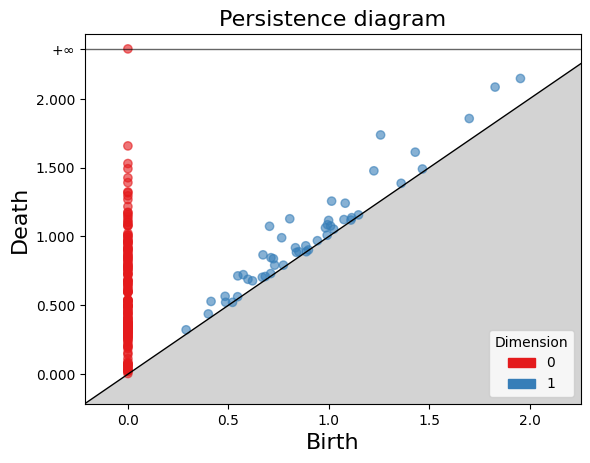

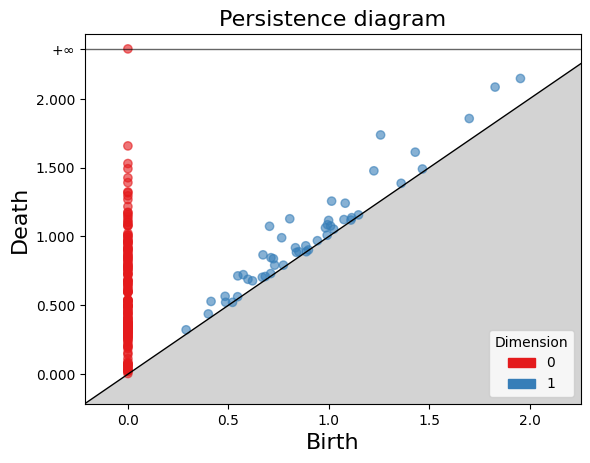

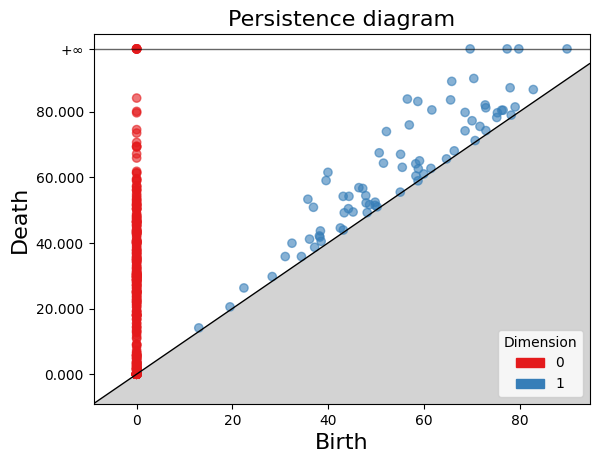

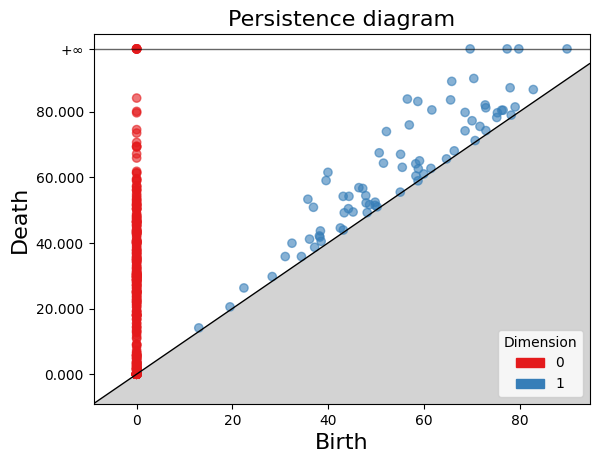

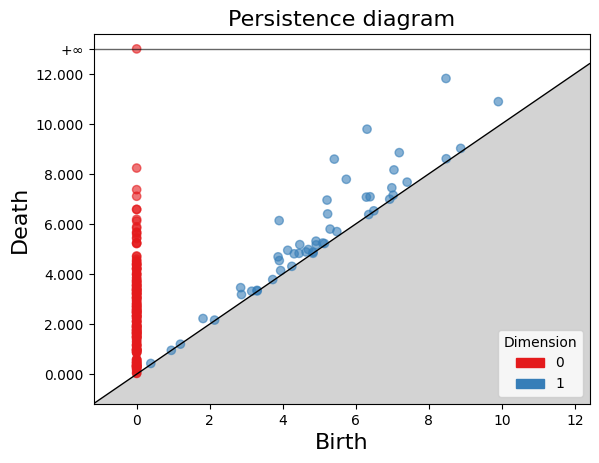

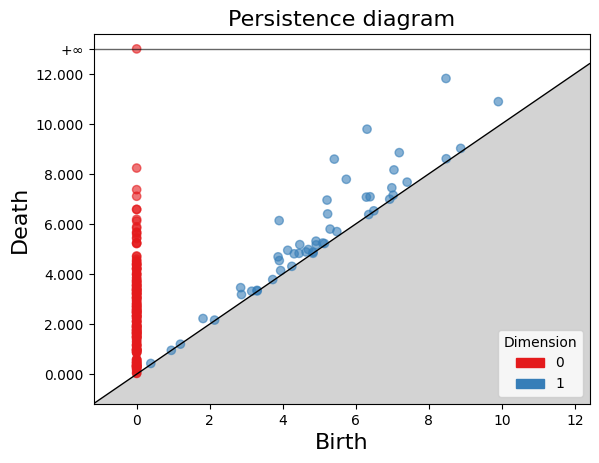

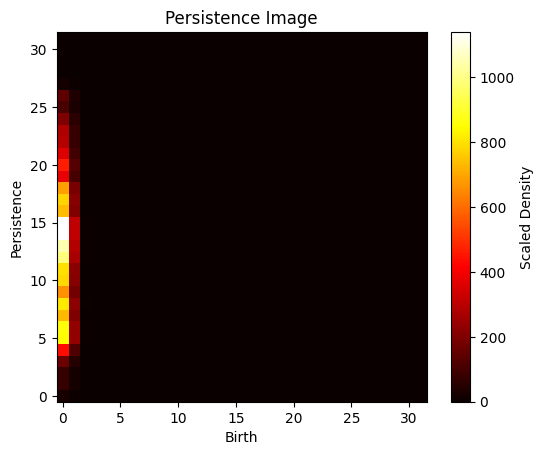

Computing persistences heat map:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s]

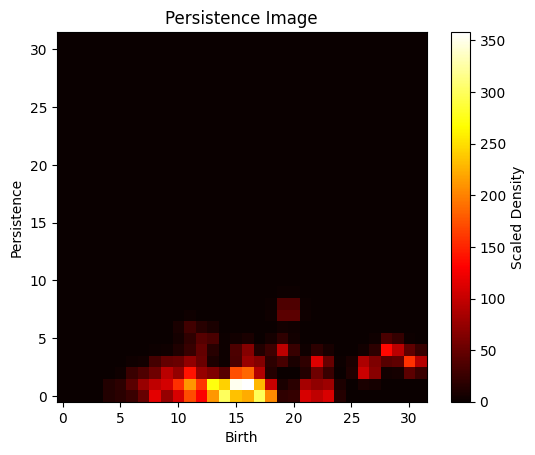

Computing persistences heat map:   0%|          | 0/2 [00:00<?, ?it/s]

(32, 32)
(32, 32)


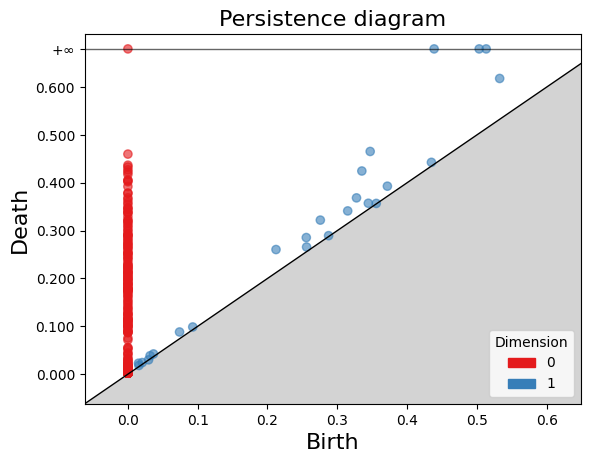

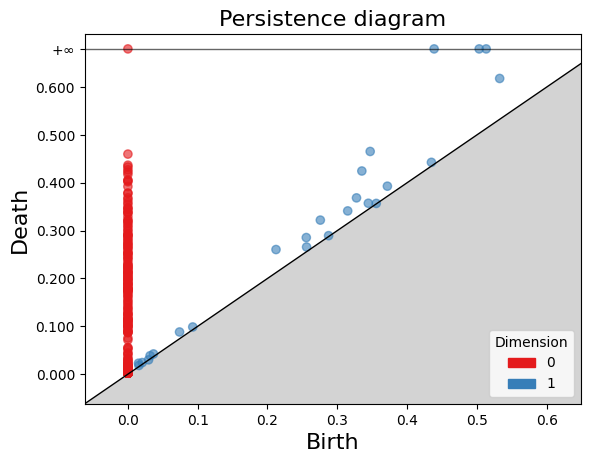

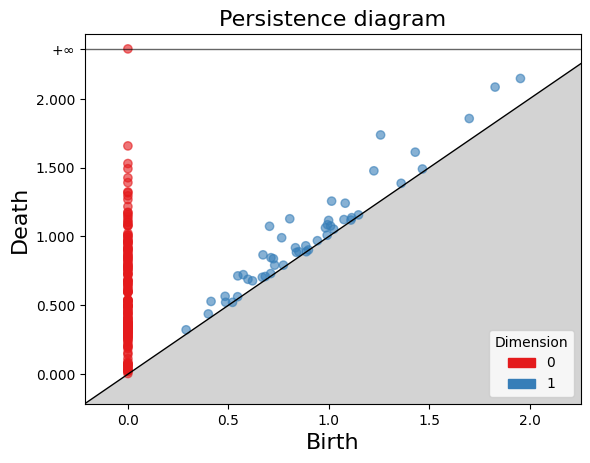

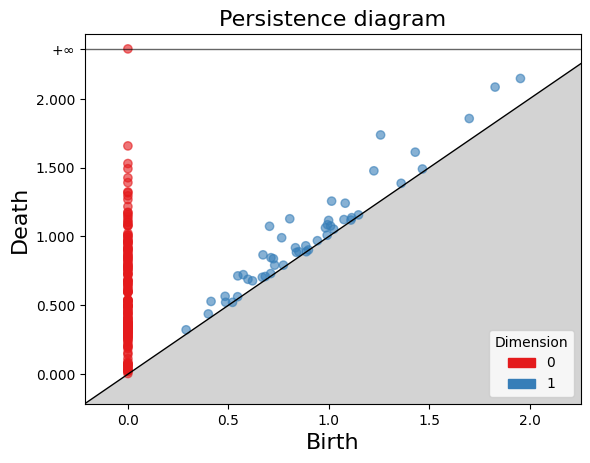

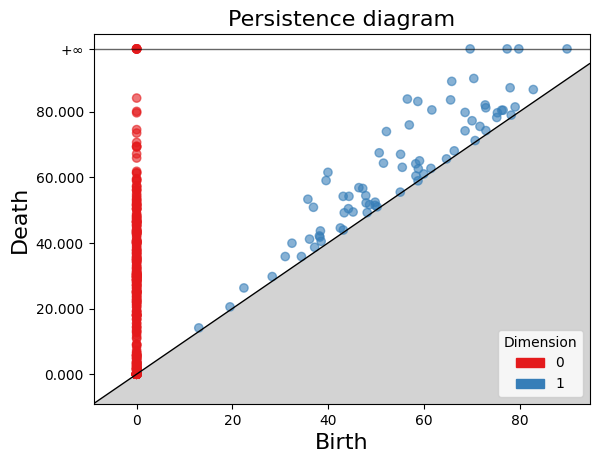

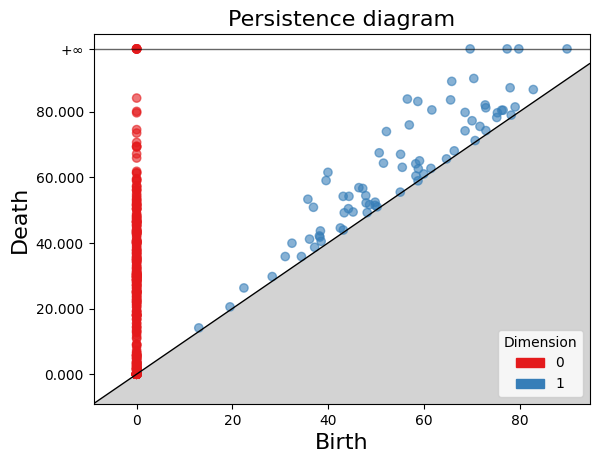

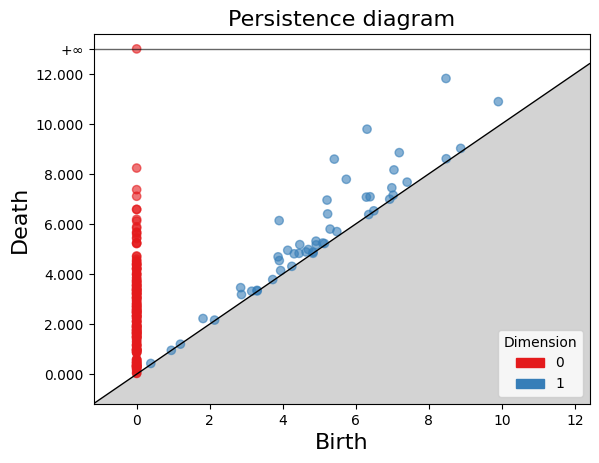

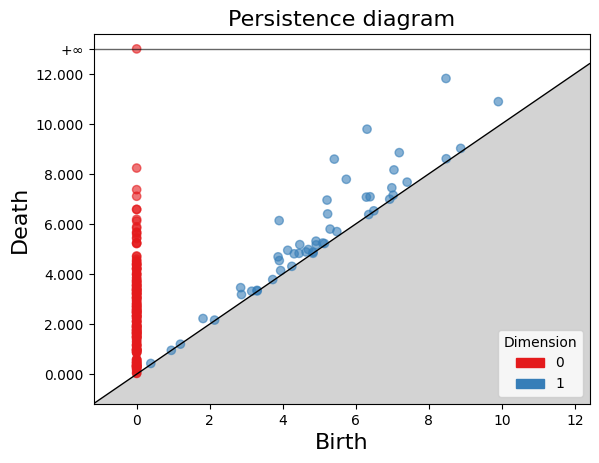

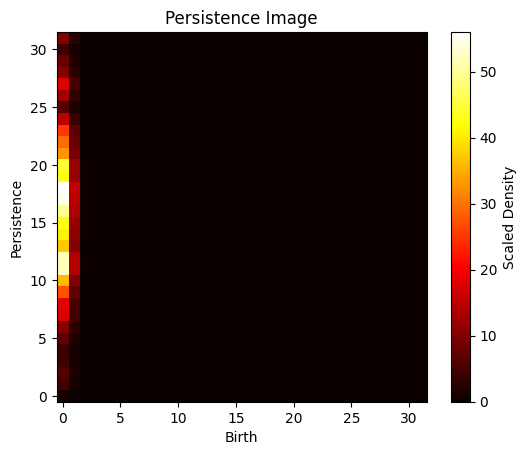

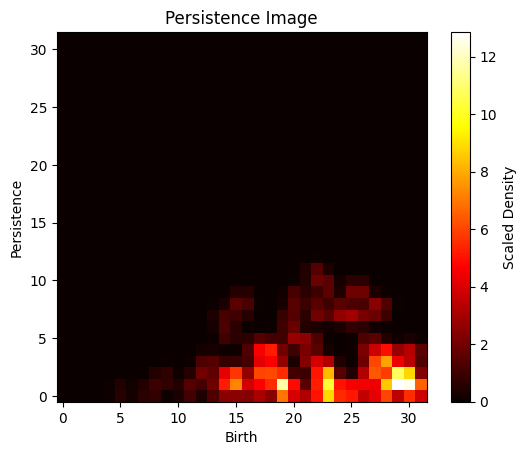

Computing persistences heat map:   0%|          | 0/2 [00:00<?, ?it/s]

(32, 32)(32, 32)



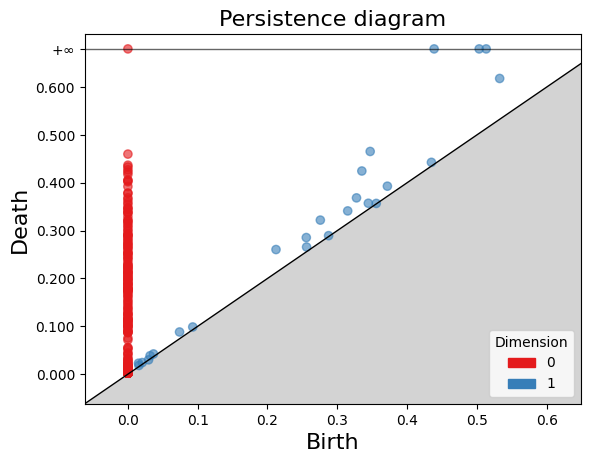

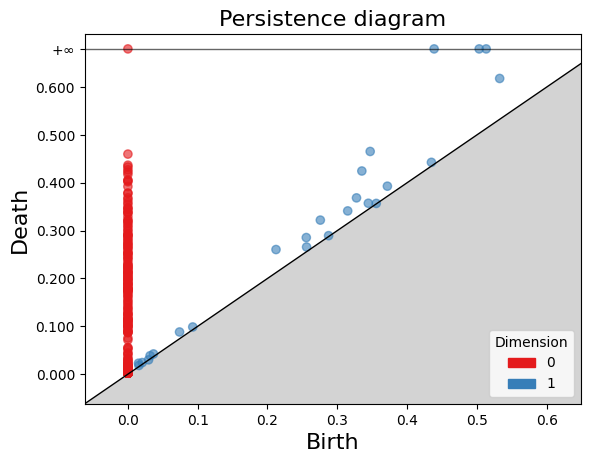

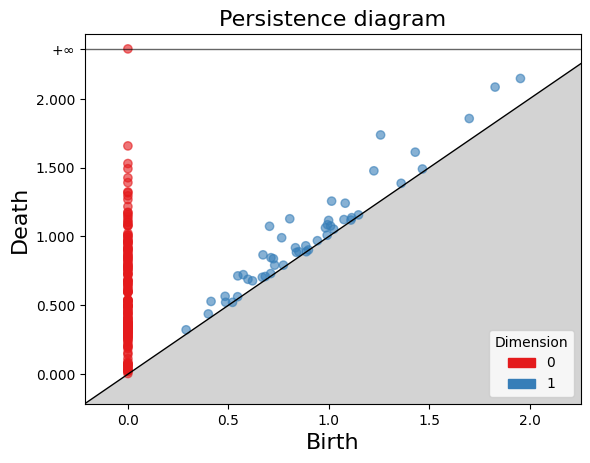

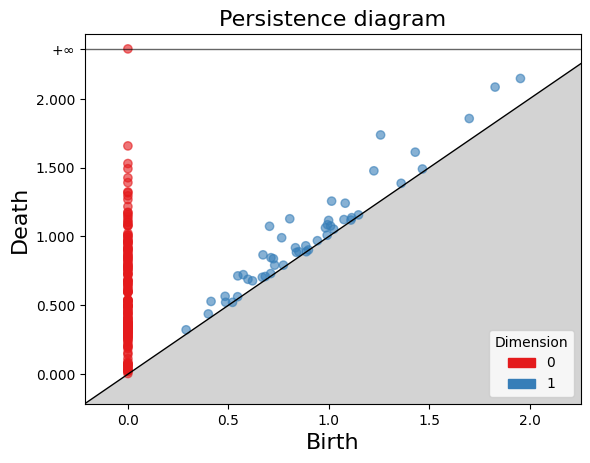

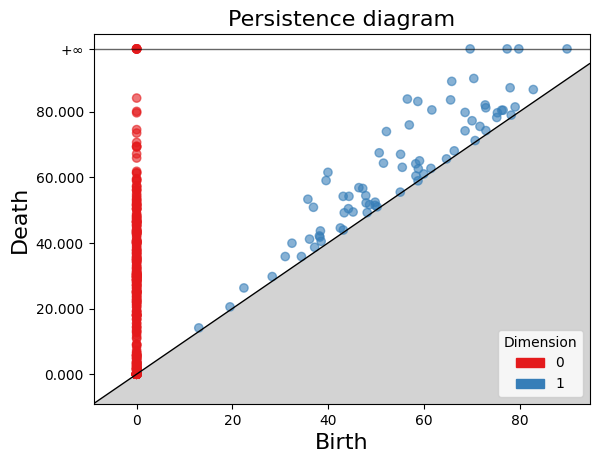

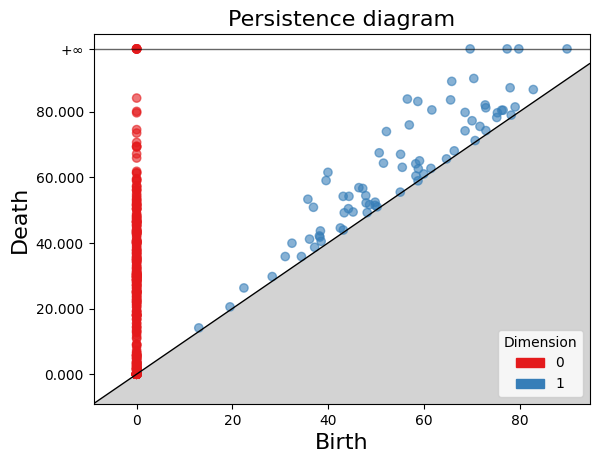

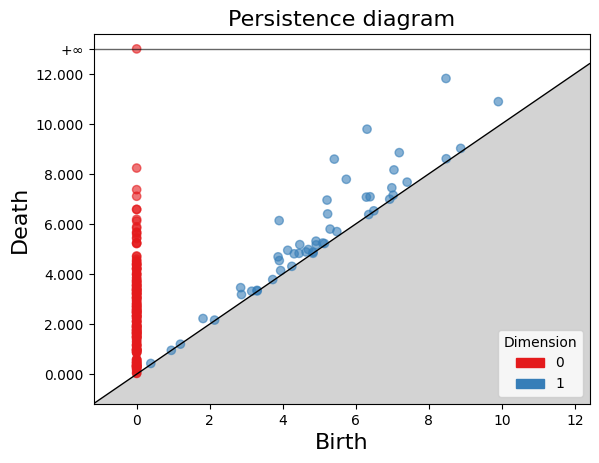

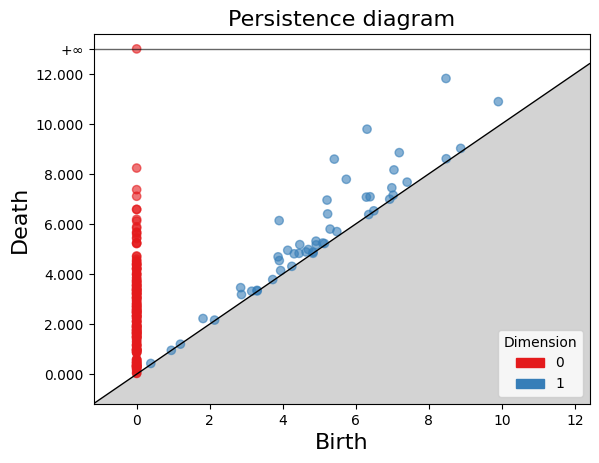

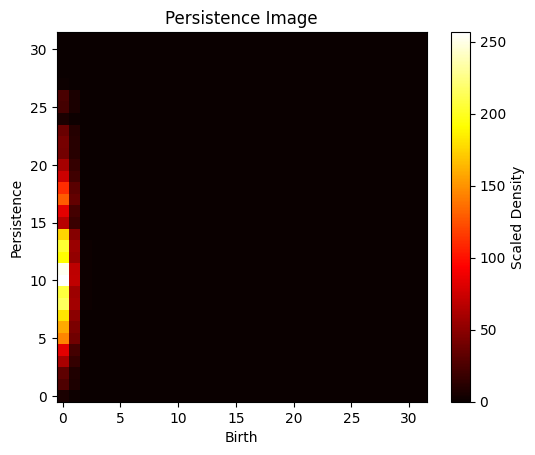

Computing persistences heat map:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s]

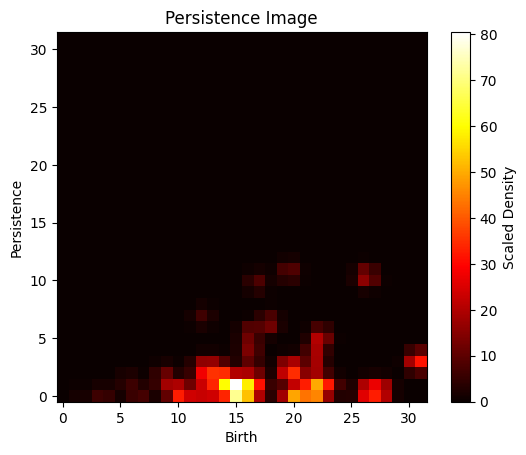

Computing persistences heat map: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


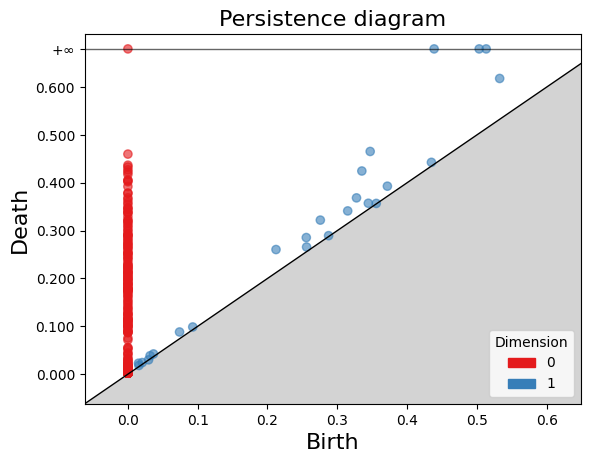

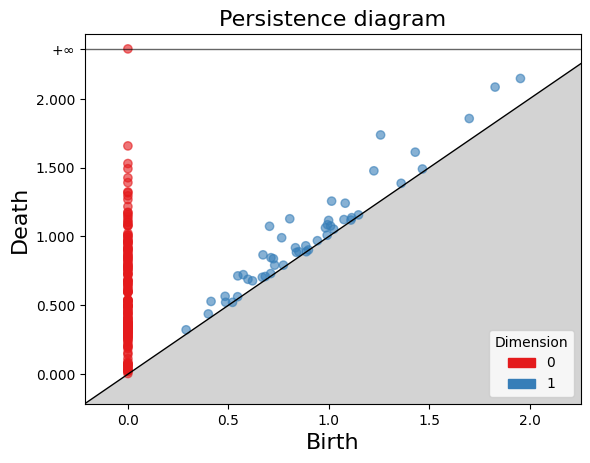

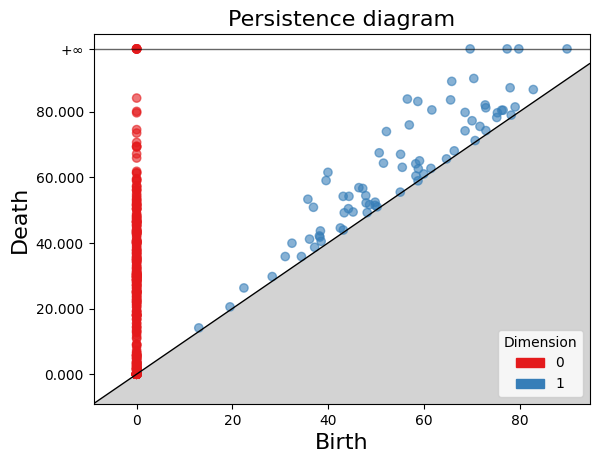

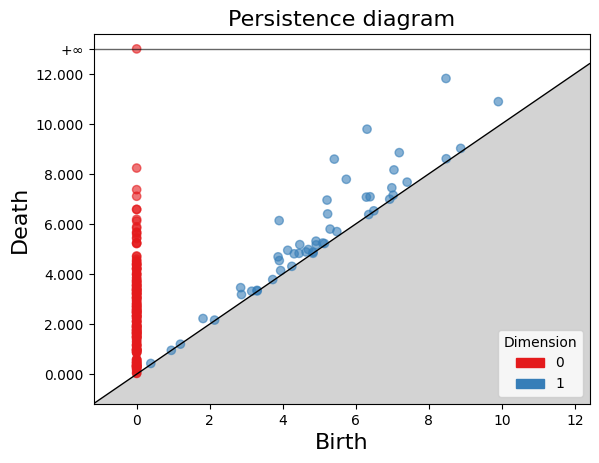

(32, 32)(32, 32)



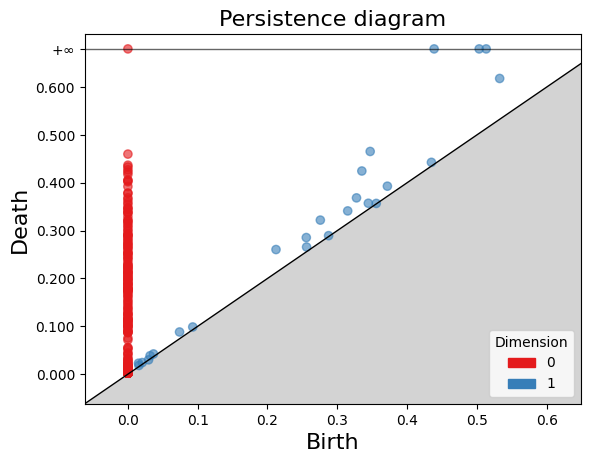

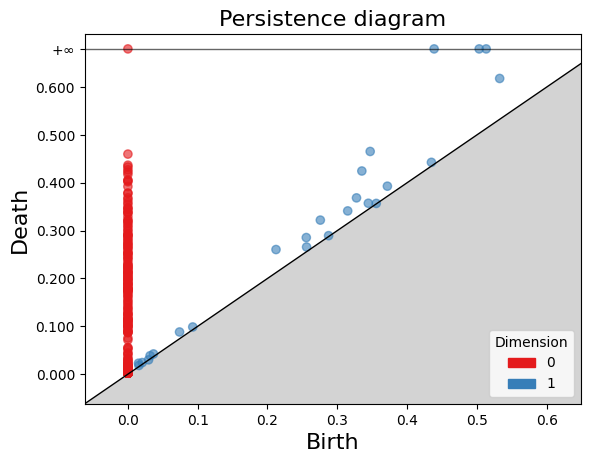

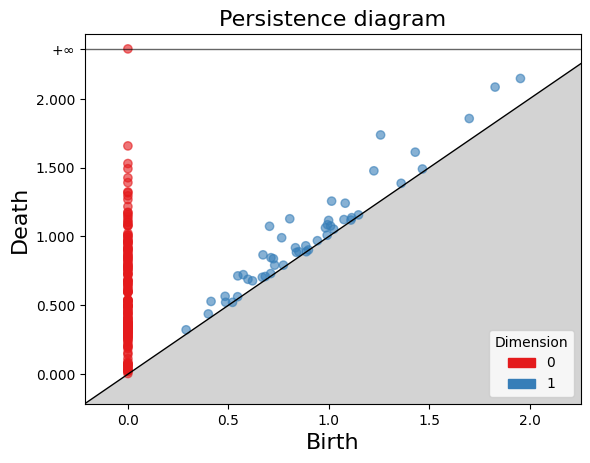

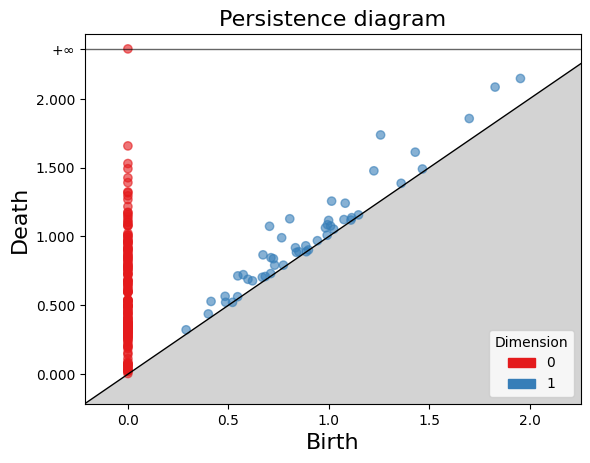

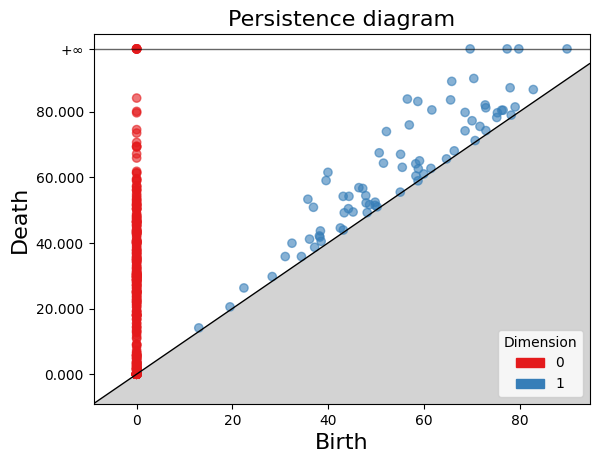

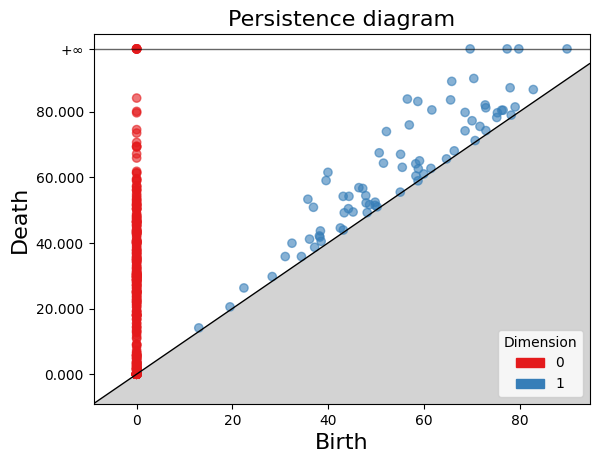

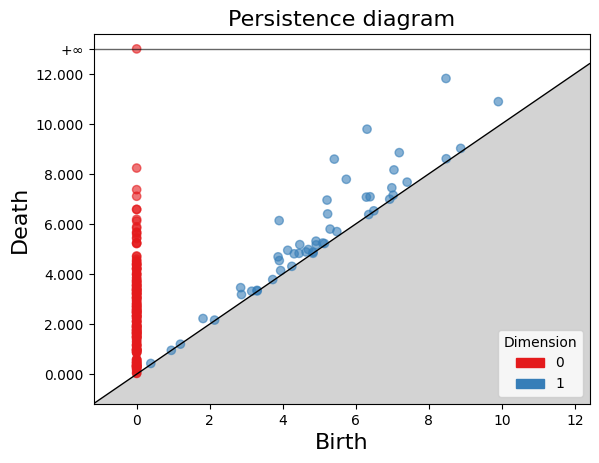

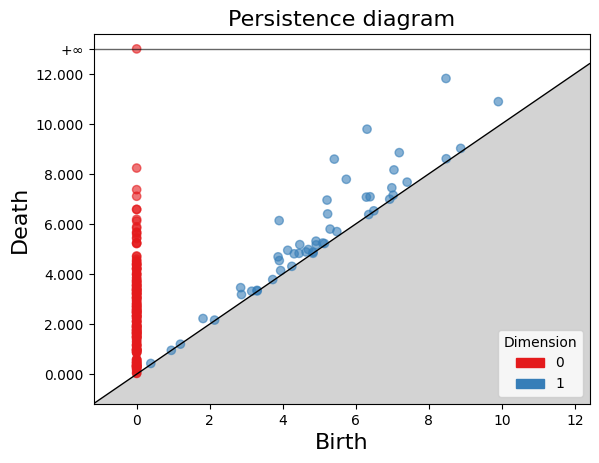

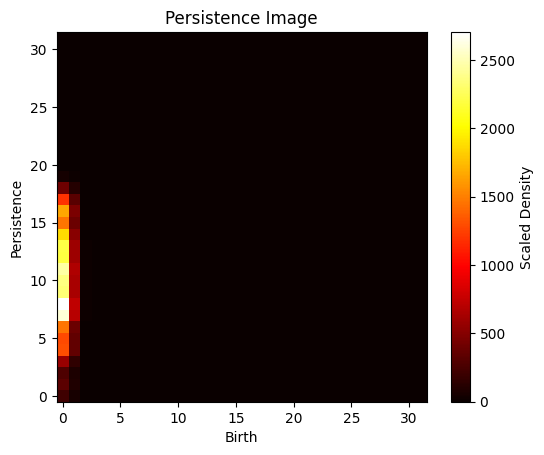

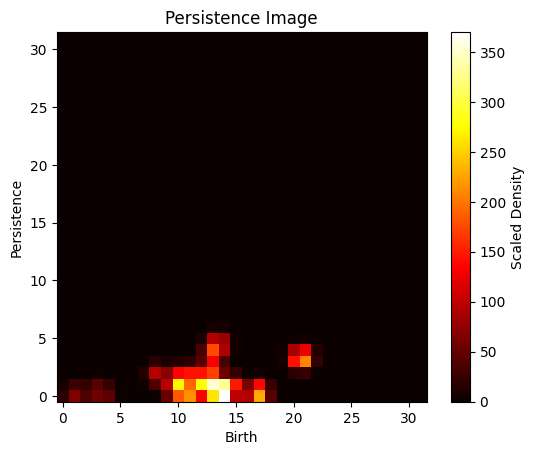

(32, 32)
(32, 32)


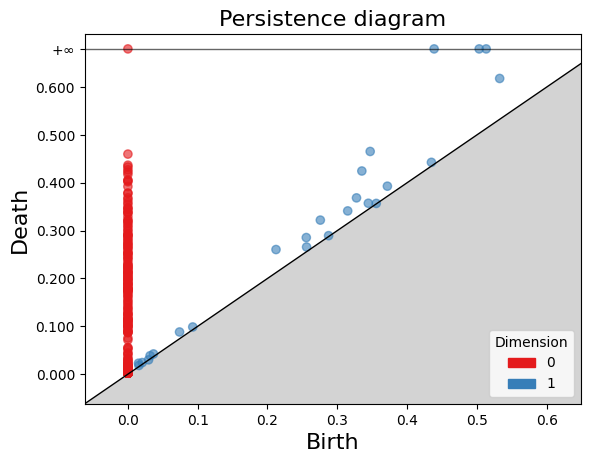

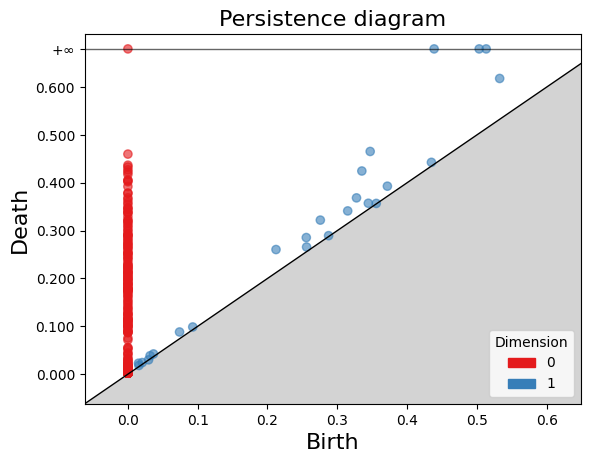

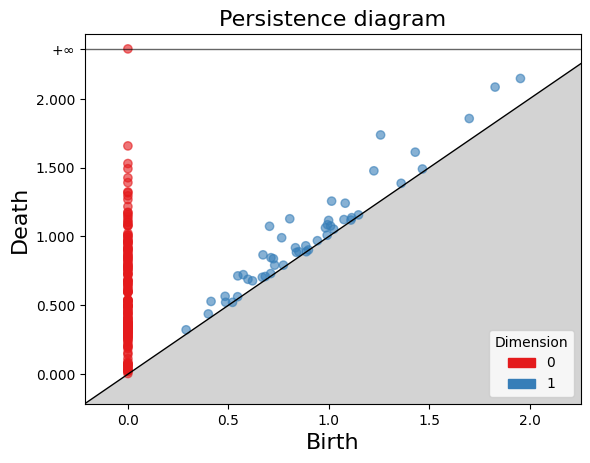

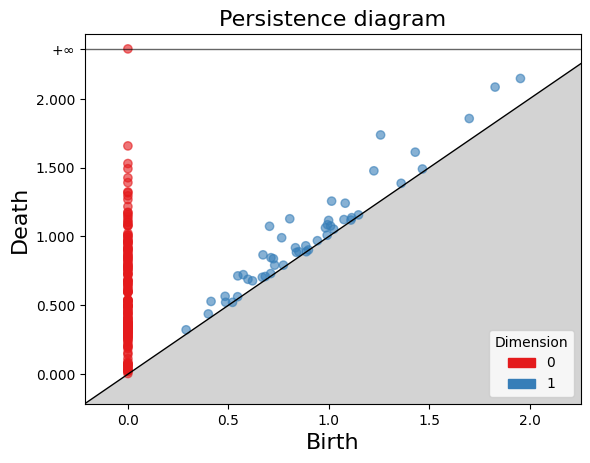

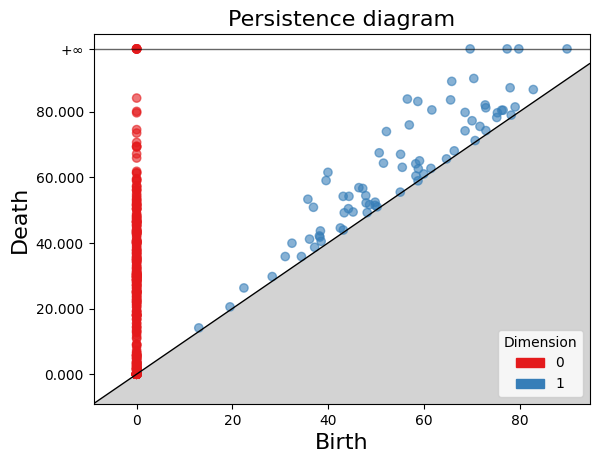

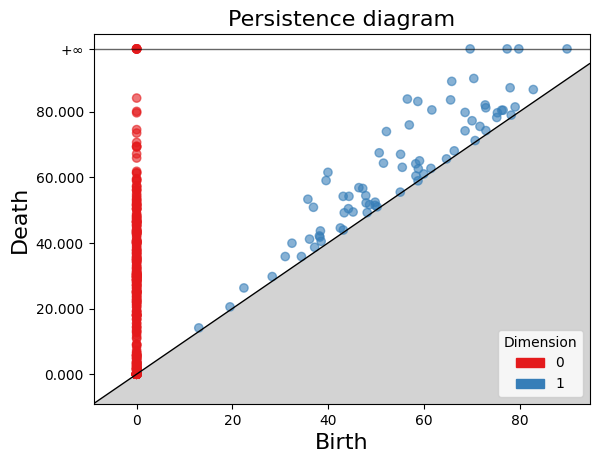

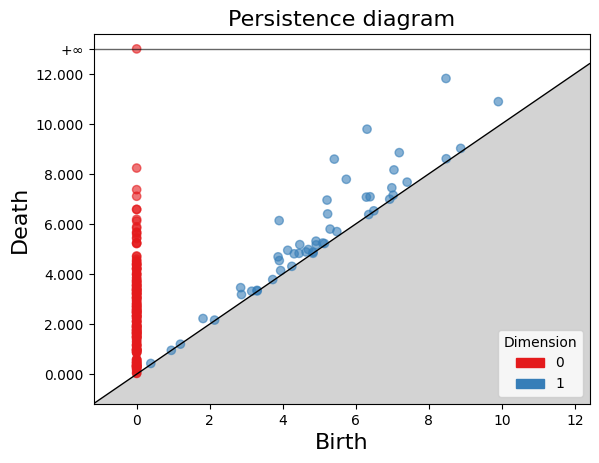

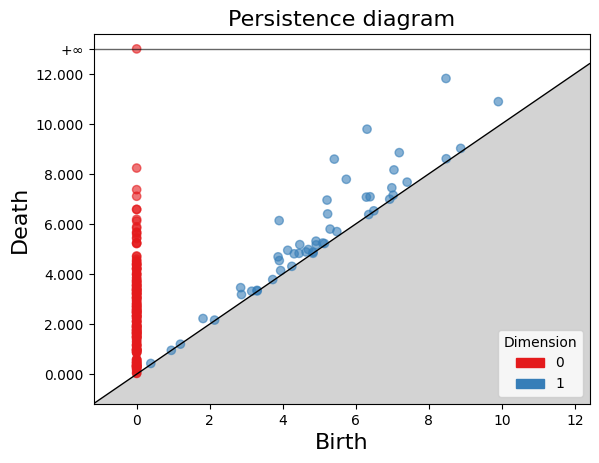

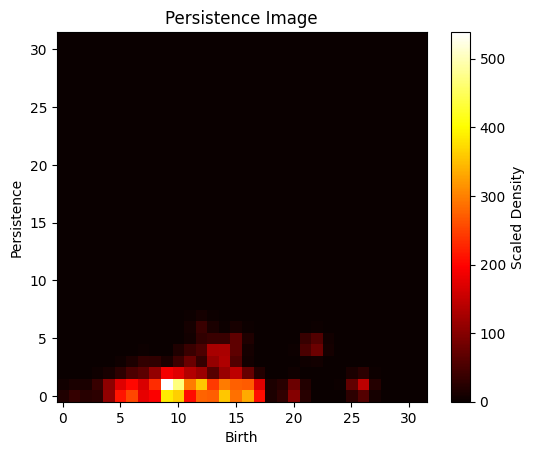

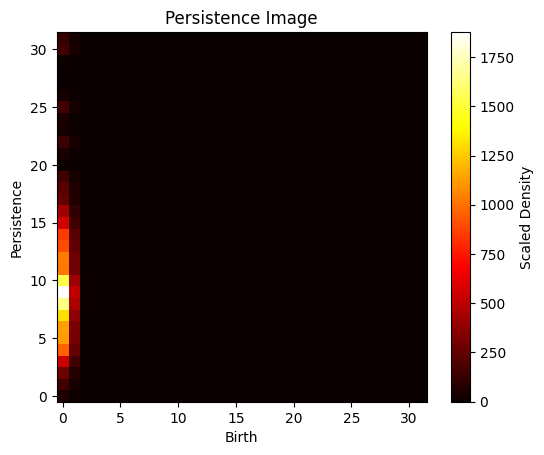

(32, 32)(32, 32)



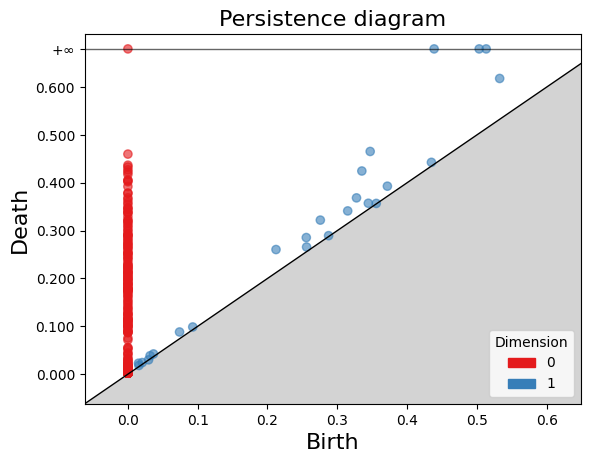

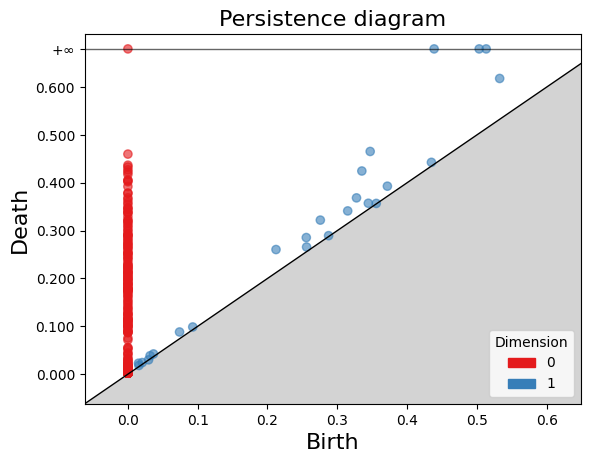

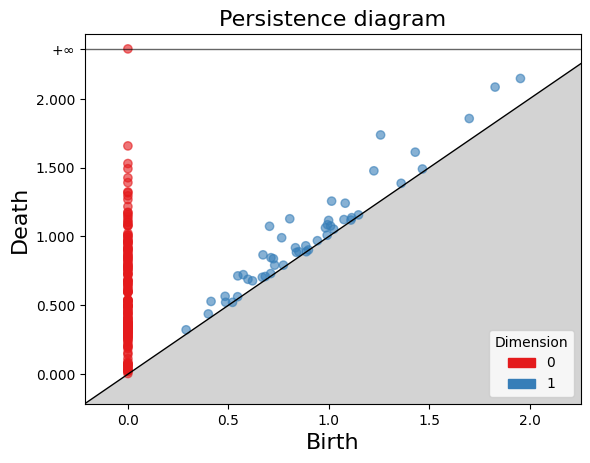

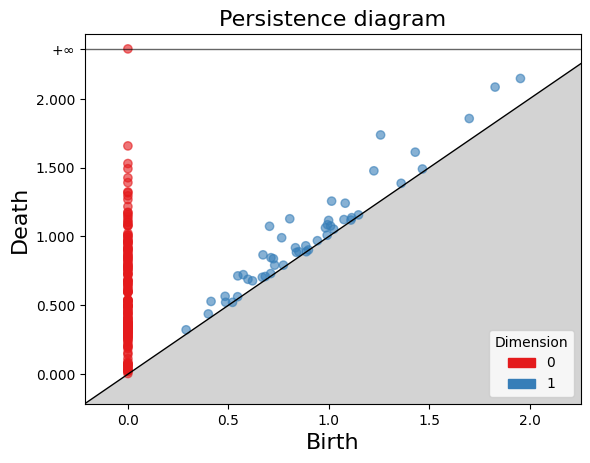

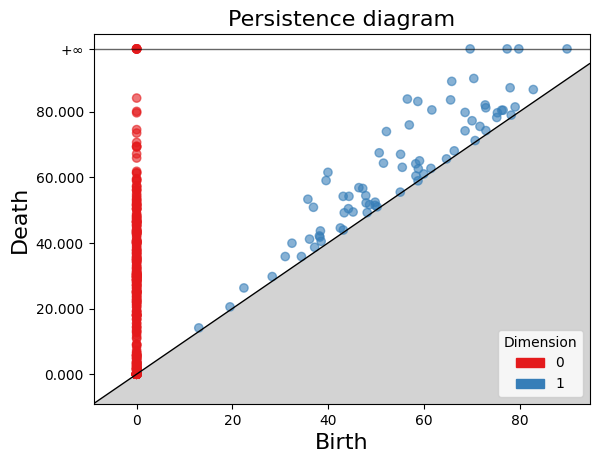

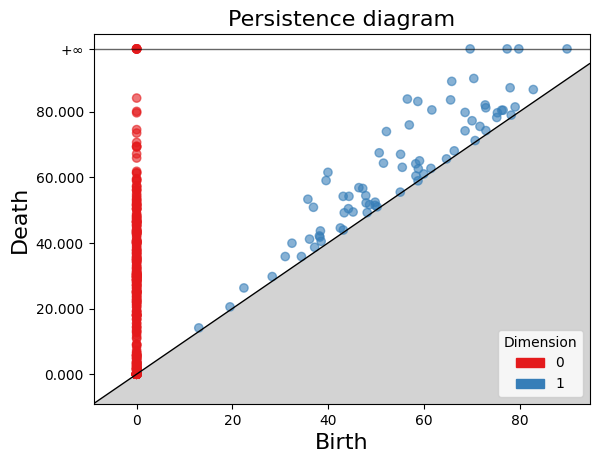

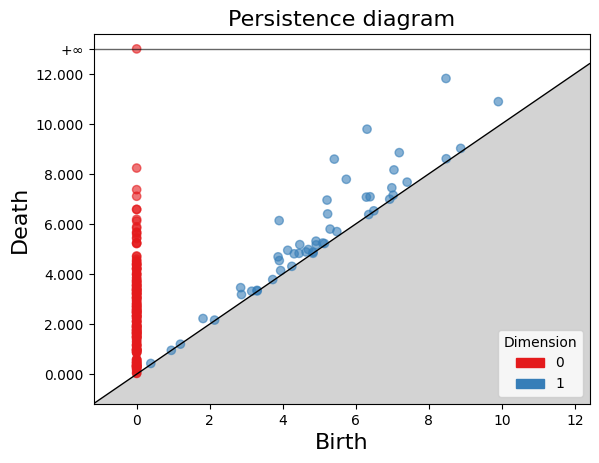

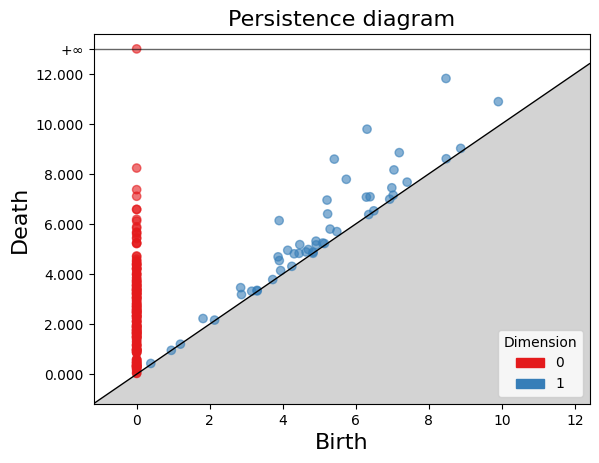

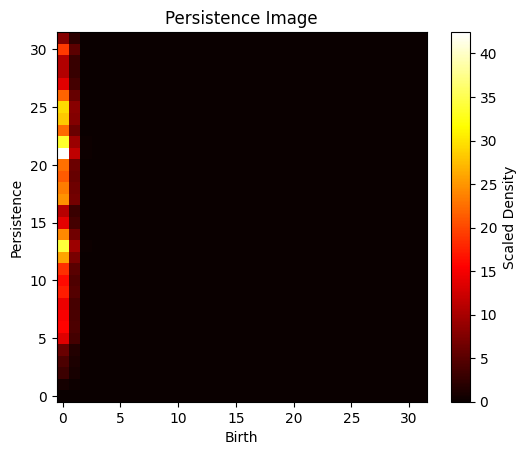

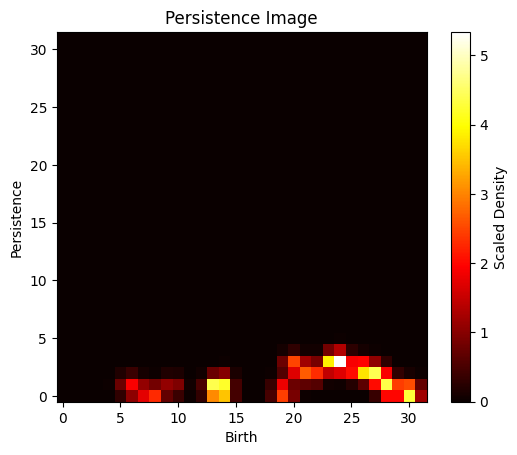

(32, 32)(32, 32)



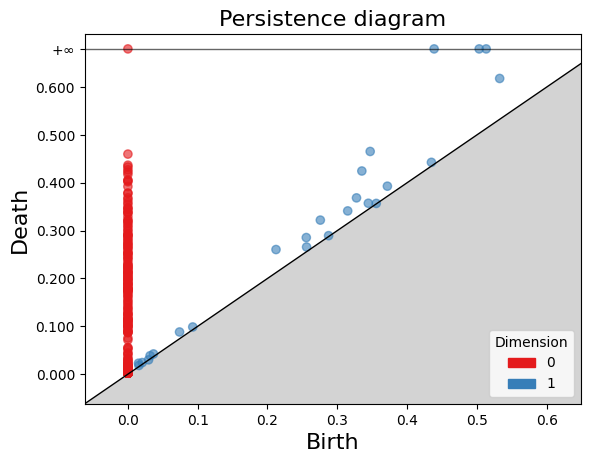

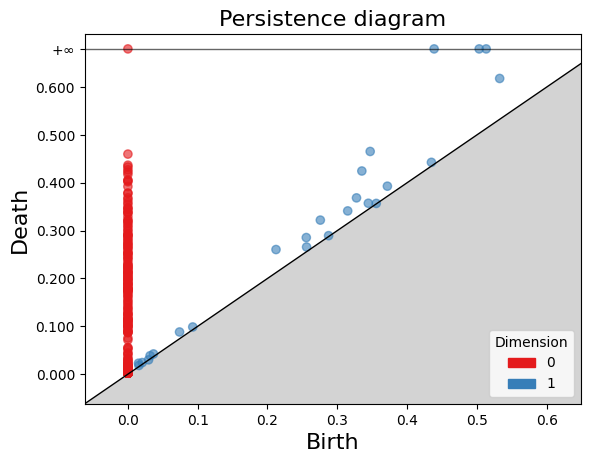

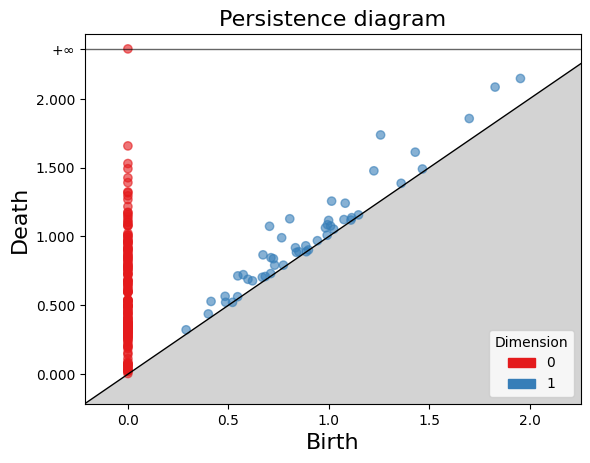

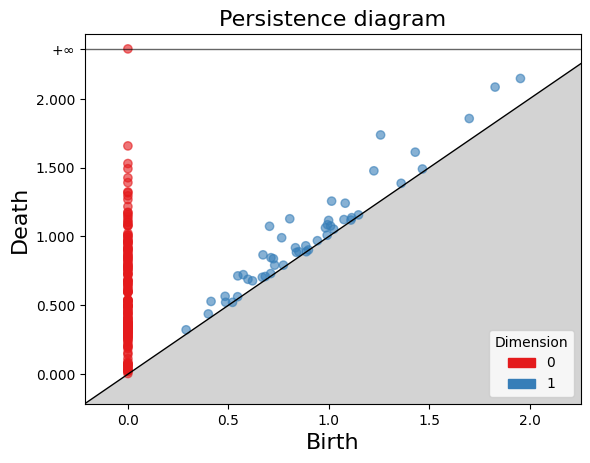

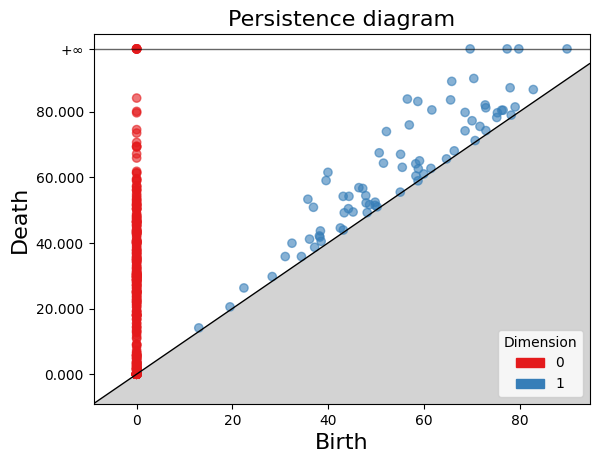

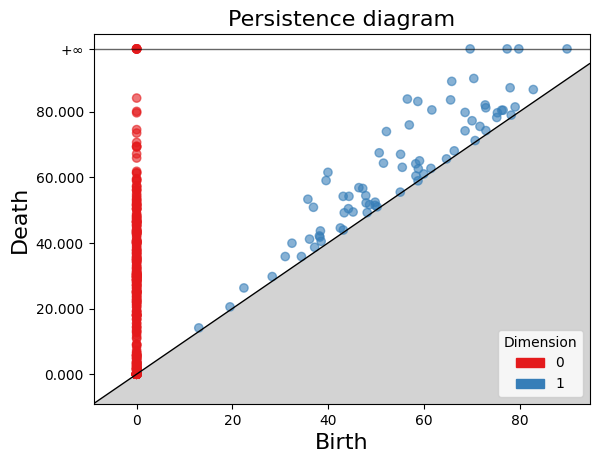

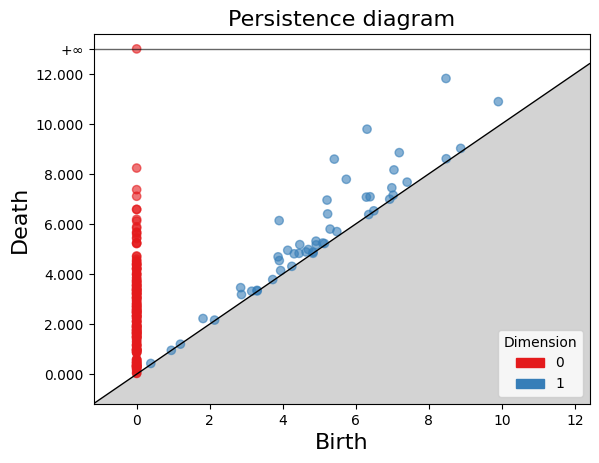

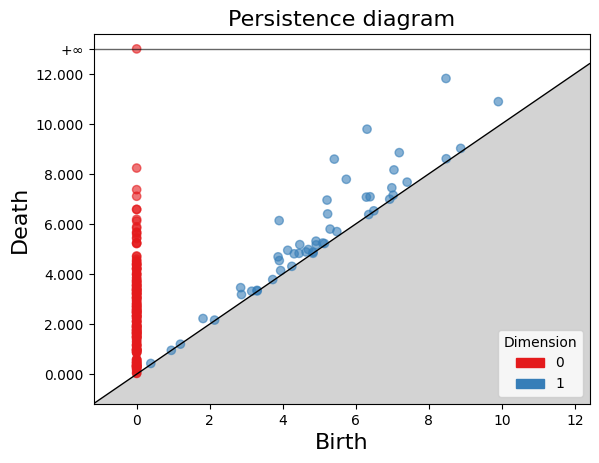

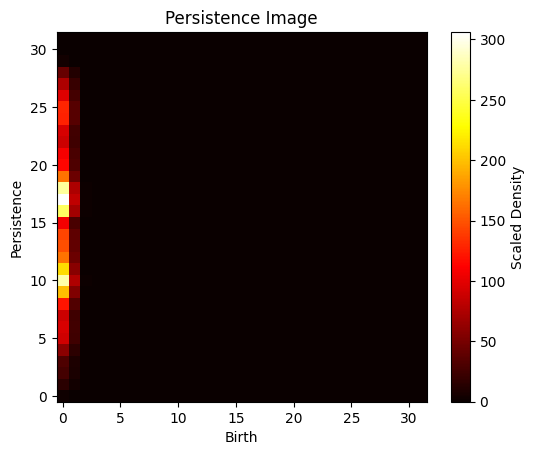

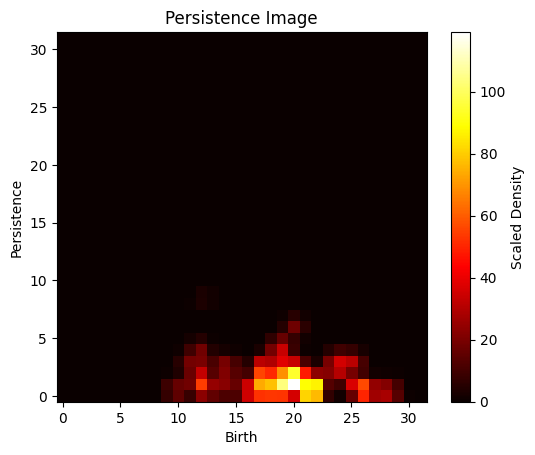

In [ ]:
myPersistenceT = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsCremad[0], aMaxLength=1.2, aMaxDim=2, aMetric=timeBasedEuclideanMetric, aPlot=True, aNormalize=True)
myPersistenceW = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsRadvess[0], aMaxLength=2.5, aMaxDim=2, aMetric=wasserstein_distance, aPlot=True, aNormalize=False)
myPersistenceE = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsSavee[0], aMaxLength=100, aMaxDim=2, aMetric=euclideanMetric, aPlot=True, aNormalize=False)
myPersistenceWM = computerPersistenceDiagrams(aMatrix=myMfccTess[0], aMaxLength=15, aMaxDim=2, aMetric=wasserstein_distance, aPlot=True, aNormalize=False)

heatmaps = getPersitanceHeatMap(aArr=[myPersistenceT], aMax=0.8, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceW], aMax=2, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceE], aMax=80, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceWM], aMax=10, aMaxDim=2, aPlot=True)

Computing persistences heat map: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


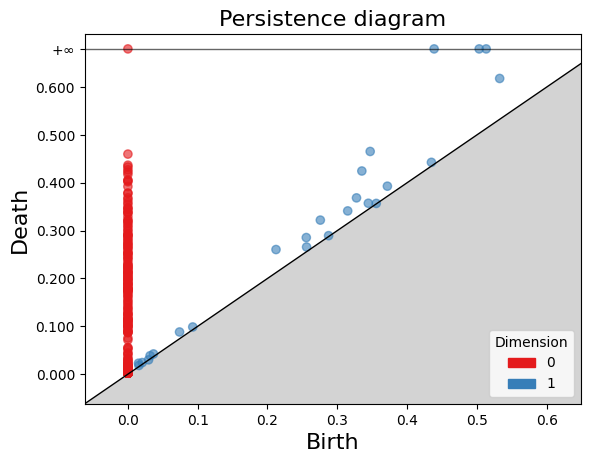

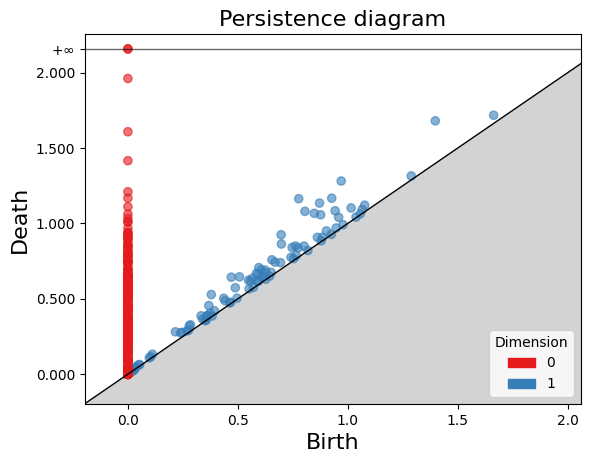

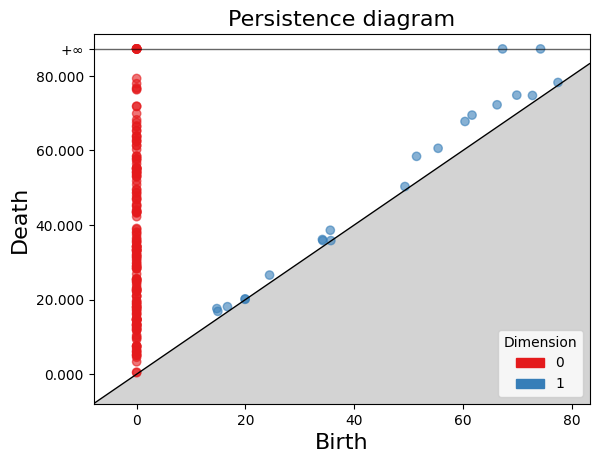

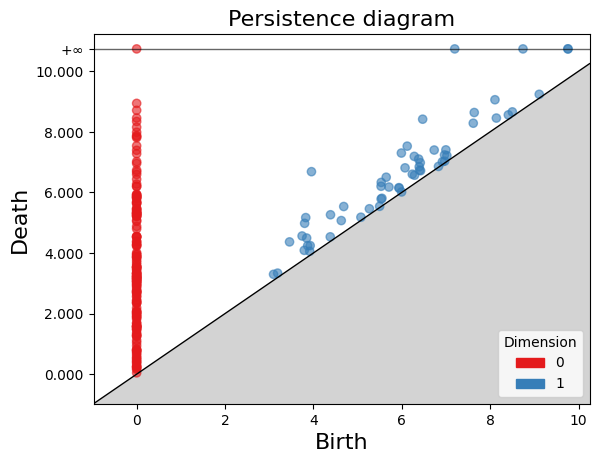

In [36]:
myPersistenceT = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsCremad[0], aMaxLength=0.8, aMaxDim=2, aMetric=timeBasedEuclideanMetric, aPlot=True, aNormalize=True)
myPersistenceW = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsSavee[0], aMaxLength=2, aMaxDim=2, aMetric=wasserstein_distance, aPlot=True, aNormalize=False)
myPersistenceE = computerPersistenceDiagrams(aMatrix=myMelSpectrogramsTess[0], aMaxLength=80, aMaxDim=2, aMetric=euclideanMetric, aPlot=True, aNormalize=False)
myPersistenceWM = computerPersistenceDiagrams(aMatrix=myMfccRadvess[0], aMaxLength=10, aMaxDim=2, aMetric=wasserstein_distance, aPlot=True, aNormalize=False)

heatmaps = getPersitanceHeatMap(aArr=[myPersistenceT], aMax=0.8, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceW], aMax=2, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceE], aMax=80, aMaxDim=2, aPlot=True)
heatmaps = getPersitanceHeatMap(aArr=[myPersistenceWM], aMax=10, aMaxDim=2, aPlot=True)

In [37]:
def parallelComputePersitence(args):
    return computePersistanceFromDb(*args)

In [38]:
def saveResults(aPattern, aResults, aMaxDim, dataset, actors, emotions):
    for i in range(len(aResults)):
        for k in range(len(aResults[i])):
            myDataset = dataset[i]
            myActor = actors[i][k]
            myEmotion = emotions[i][k]
            for j in range(aMaxDim):
                np.save(f'./savefiles/{aPattern}_{myDataset}_{myActor}_{myEmotion}_{i}_{k}_{j}.npy', aResults[i][k][j])

In [39]:
def computeHeatMaps(aResults, aMaxDim, aMaxDist, aName, dataset, actors, emotions):
    myNewHeat = []
    for i in range(len(aResults)):
        # print(f'Computing {i}')
        myHeat = getPersitanceHeatMap(aResults[i], aMax=aMaxDist, aMaxDim=aMaxDim)
        myNewHeat.append(myHeat)
        for j in range(len(myNewHeat[i])):
            # print(j)
            myDataset = dataset[i]
            myActor = actors[i][j // 2]
            myEmotion = emotions[i][j // 2]
            np.save(f'./savefiles/{aName}Heat_{myDataset}_{myActor}_{myEmotion}_{i}_{j}.npy', myNewHeat[i][j])

In [40]:
maxdim = 2
metrics = [timeBasedEuclideanMetric, wasserstein_distance, euclideanMetric]
scaled = [True, False, False]
maxdists = [0.8, 2, 80]
names = ['timeMetric', 'wasserstein', 'euclidean']
for metric, scale, maxdist, name in zip(metrics, scaled, maxdists, names):
    args = [
        (myMelSpectrogramsCremad, maxdist, maxdim, metric, False, len(myMelSpectrogramsCremad), scale),
        (myMelSpectrogramsSavee, maxdist, maxdim, metric, False, len(myMelSpectrogramsSavee), scale),
        (myMelSpectrogramsRadvess, maxdist, maxdim, metric, False, len(myMelSpectrogramsRadvess), scale),
        (myMelSpectrogramsTess, maxdist, maxdim, metric, False, len(myMelSpectrogramsTess), scale),
    ]
    results = []
    for arg in args:
        results.append(parallelComputePersitence(arg))
    saveResults(aPattern=name, aResults=results, aMaxDim=maxdim, dataset=['cremad', 'savee', 'radvess', 'tess'], actors=[myCremadActors, mySaveeActors, myRadvessActors, myTessActors], emotions=[myCremadEmotions, mySaveeEmotions, myRadvessEmotions, myTessEmotions])
    computeHeatMaps(aResults=results, aMaxDim=maxdim, aMaxDist=maxdist, aName=name, dataset=['cremad', 'savee', 'radvess', 'tess'], actors=[myCremadActors, mySaveeActors, myRadvessActors, myTessActors], emotions=[myCremadEmotions, mySaveeEmotions, myRadvessEmotions, myTessEmotions])
    print('To the next!')

Computing persistences heat map: 100%|██████████| 9600/9600 [00:04<00:00, 1989.62it/s]


To the next!


Computing persistences heat map: 100%|██████████| 9600/9600 [00:04<00:00, 2014.38it/s]


To the next!


Computing persistences heat map: 100%|██████████| 9600/9600 [00:04<00:00, 2037.36it/s]


To the next!


In [41]:
maxDim = 2
maxdist = 15
args = [
    (myMfccCremad, maxdist, maxdim, metric, False, len(myMfccCremad), scale),
    (myMfccSavee, maxdist, maxdim, metric, False, len(myMfccSavee), scale),
    (myMfccRadvess, maxdist, maxdim, metric, False, len(myMfccRadvess), scale),
    (myMfccTess, maxdist, maxdim, metric, False, len(myMfccTess), scale),
]
results = []
for arg in args:
    results.append(parallelComputePersitence(arg))
saveResults(aPattern='wassersteinMfcc', aResults=results, aMaxDim=maxDim, dataset=['cremad', 'savee', 'radvess', 'tess'], actors=[myCremadActors, mySaveeActors, myRadvessActors, myTessActors], emotions=[myCremadEmotions, mySaveeEmotions, myRadvessEmotions, myTessEmotions])
computeHeatMaps(aResults=results, aMaxDim=maxDim, aMaxDist=maxdist, aName='wassersteinMfcc', dataset=['cremad', 'savee', 'radvess', 'tess'], actors=[myCremadActors, mySaveeActors, myRadvessActors, myTessActors], emotions=[myCremadEmotions, mySaveeEmotions, myRadvessEmotions, myTessEmotions])


Computing persistences heat map: 100%|██████████| 9600/9600 [00:04<00:00, 2064.06it/s]


In [31]:
myMelSpectrogramsCremad = doMelSpectrogram(myCremadSounds, True)
myMelSpectrogramsRadvess = doMelSpectrogram(myRadvessSounds, True)
myMelSpectrogramsSavee = doMelSpectrogram(mySaveeSounds, True)
myMelSpectrogramsTess = doMelSpectrogram(myTessSounds, True)

100%|██████████| 4800/4800 [00:15<00:00, 313.16it/s]


In [32]:
myMfccRadvess = computeMfccs(myMelSpectrogramsRadvess)
myMfccCremad = computeMfccs(myMelSpectrogramsCremad)
myMfccSavee = computeMfccs(myMelSpectrogramsSavee)
myMfccTess = computeMfccs(myMelSpectrogramsTess)

100%|██████████| 4800/4800 [00:00<00:00, 21092.03it/s]


In [44]:
for i in range(len(myMelSpectrogramsCremad)):
    np.save(f'./savefiles/cremad_{myCremadActors[i]}_{myCremadEmotions[i]}_{i}.npy', myMelSpectrogramsCremad[i])
for i in range(len(myMelSpectrogramsRadvess)):
    np.save(f'./savefiles/radvess_{myRadvessActors[i]}_{myRadvessEmotions[i]}_{i}.npy', myMelSpectrogramsRadvess[i])
for i in range(len(myMelSpectrogramsSavee)):
    np.save(f'./savefiles/savee_{mySaveeActors[i]}_{mySaveeEmotions[i]}_{i}.npy', myMelSpectrogramsSavee[i])
for i in range(len(myMelSpectrogramsTess)):
    np.save(f'./savefiles/tess_{myTessActors[i]}_{myTessEmotions[i]}_{i}.npy', myMelSpectrogramsTess[i])

In [ ]:
for i in range(len(myMfccCremad)):
    np.save(f'./savefiles/mfcc_cremad_{myCremadActors[i]}_{myCremadEmotions[i]}_{i}.npy', myMfccCremad[i])
for i in range(len(myMfccRadvess)):
    np.save(f'./savefiles/mfcc_radvess_{myRadvessActors[i]}_{myRadvessEmotions[i]}_{i}.npy', myMfccRadvess[i])
for i in range(len(myMfccSavee)):
    np.save(f'./savefiles/mfcc_savee_{mySaveeActors[i]}_{mySaveeEmotions[i]}_{i}.npy', myMfccSavee[i])
for i in range(len(myMfccTess)):
    np.save(f'./savefiles/mfcc_tess_{myTessActors[i]}_{myTessEmotions[i]}_{i}.npy', myMfccTess[i])

In [46]:
folder = './savefiles'

def findFilesFromPattern(pattern):
    pattern = re.compile(pattern + r'_(\d+)_(\d+)_(\d+)\.npy')
    heatmaps_dict = {}
    for filename in os.listdir(folder):
        match = pattern.match(filename)
        if match:
            i, j, k = map(int, match.groups())
            filepath = os.path.join(folder, filename)
            data = np.load(filepath)

            if i not in heatmaps_dict:
                heatmaps_dict[i] = []

            while len(heatmaps_dict[i]) <= j:
                heatmaps_dict[i].append([])

            while len(heatmaps_dict[i][j]) <= k:
                heatmaps_dict[i][j].append(None)

            heatmaps_dict[i][j][k] = data
    return [heatmaps_dict[i] for i in sorted(heatmaps_dict.keys())]

In [35]:
import os

# Path to your folder
folder = "savefiles/"

for filename in os.listdir(folder):
    if "_Actor_" in filename:
        new_name = filename.replace("_Actor_", "_")
        old_path = os.path.join(folder, filename)
        new_path = os.path.join(folder, new_name)
        os.rename(old_path, new_path)
        print(f"Renamed: {filename} → {new_name}")
    if 'mfcc_' == filename[0:5]:
        os.remove(os.path.join(folder, filename))